# Predicting Number of Houses Damaged by Typhoons in Philippines  

Based on: 
* census data about municipalities
* meteorogical data (windspeed, rain fall)
* geographical data (distance to typhoon path) 
* statistic about damage caused by 4 typhoons: Melor, Hagupit, Rammasun, Haiyan








# Steps: 
####   1. Loading and manipulating data
####    2. Finding best learning parametrs for RandomForestRegressor, GradientBoostingRegressor
####    3. Building various models to estimate their predictive power with growing number of data
    a. Model growing chronogically with next typhoons
    b. Model based on 3 typhoons, evaluated using crossvalidation on the remaining one (compared RandomForest with GradientBoosting)
    
####   4. Comparing models performance while adding data from next typhoons
####   5. Building final model using the best scoring algorithm, based on all typhoons
####   6. Serializing the model. 


----

In [117]:
%pylab inline
import pandas as pd
import numpy as np
import cPickle
from sklearn import metrics
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.tree import export_graphviz
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.cross_validation import  cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image  
import seaborn

Populating the interactive namespace from numpy and matplotlib


## 1. Loading and manipulatig data 
* Deleting Unnamed: 0 column
* Ignoring Census 2010 data
* Filling poverty data with mean
* Adding estimated poor counts (based on previous experiments adding this parameter increases model performance


In [118]:
T = pd.read_csv("../4 typhoons/matrix_4typhoons.csv")
T.index = T['M_Code']
OriginalT = T

In [119]:
T.columns

Index([u'Unnamed: 0', u'M_Code', u'Municipality', u'Area (km2)',
       u'Population 2010 census', u'Population 2015 census',
       u'Pop. Density 2015 per km2', u'Poverty (%)', u'Rainfallme',
       u'Houses damaged', u'average_speed_mph', u'distance_typhoon_km',
       u'typhoon_name', u'perc_house_damage'],
      dtype='object')

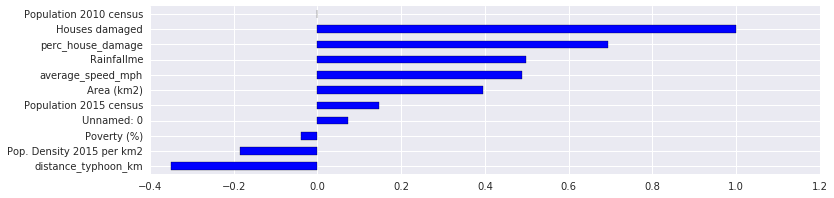

In [120]:
T.loc[T['typhoon_name'] == 'Hagupit'].corr()['Houses damaged'].sort_values().plot(kind='barh',  figsize=(12, 3))

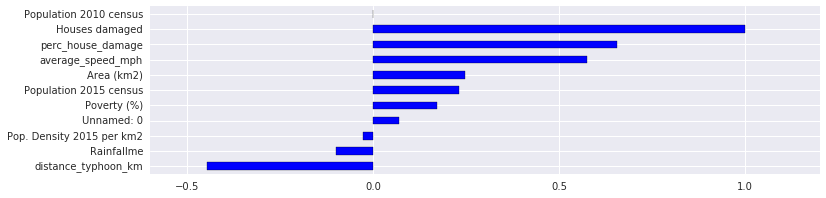

In [121]:
T.loc[T['typhoon_name'] == 'Melor'].corr()['Houses damaged'].sort_values().plot(kind='barh',  figsize=(12, 3))

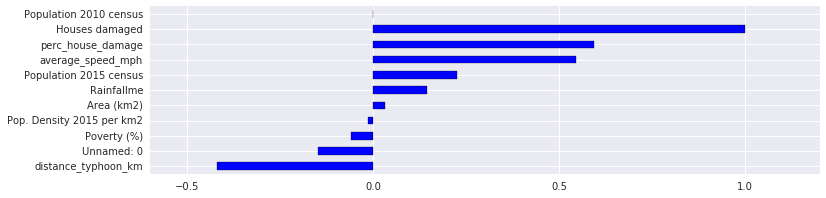

In [122]:
T.loc[T['typhoon_name'] == 'Rammasun'].corr()['Houses damaged'].sort_values().plot(kind='barh',  figsize=(12, 3))

##### Data preparation

In [123]:
del T['Unnamed: 0']

In [124]:
del T['Population 2010 census']

In [125]:
T[['Poverty (%)']] = T[['Poverty (%)']].fillna(T[['Poverty (%)']].mean())

In [126]:
T['Poor'] = T['Poverty (%)'] * T['Population 2015 census']

## 2. Finding best learning parameters

In [27]:
X = T[[u'Area (km2)', u'Population 2015 census',
       u'Pop. Density 2015 per km2', u'Poverty (%)', u'Rainfallme',  u'average_speed_mph', u'distance_typhoon_km', u'Poor']]
y = T['Houses damaged']

In [36]:
rf = RandomForestRegressor(n_estimators=200)
param_grid = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'min_samples_leaf': [2, 5, 10, 20]
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 10)
CV_rf.fit(X, y)
print CV_rf.best_params_

{'max_features': 'log2', 'n_estimators': 50, 'min_samples_leaf': 5}


In [39]:
gb = GradientBoostingRegressor(n_estimators=200)
param_grid = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'min_samples_leaf': [2, 5, 10, 20]
}
CV = GridSearchCV(estimator=gb, param_grid=param_grid, cv= 10)
CV.fit(X, y)
print CV.best_params_

{'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_leaf': 10}


# 3. Training various models with selected params

In [164]:
typhoons = [  'Haiyan', 'Rammasun','Hagupit', 'Melor']
mae = []
r2 = []
medians = []

## 3a. Evaluation model growing chronogically with next typhoons

In [165]:
rf = RandomForestRegressor(max_features= 'sqrt', n_estimators= 50, min_samples_leaf= 5)
model = rf



for i in range(3): 
    selected = typhoons[:i+1]
    print '\n\nTraining on ', selected
    print 'Testing on  ', typhoons[i+1:]


    X3_train = T.loc[T['typhoon_name'].isin(selected)][[u'Area (km2)', u'Population 2015 census',
       u'Pop. Density 2015 per km2', u'Poverty (%)', u'Rainfallme',  u'average_speed_mph', u'distance_typhoon_km', u'Poor']]


    y3_train = T.loc[T['typhoon_name'].isin(selected)]['Houses damaged']

    X3_test = T.loc[T['typhoon_name'].isin(selected) == False][[u'Area (km2)', u'Population 2015 census',
       u'Pop. Density 2015 per km2', u'Poverty (%)', u'Rainfallme',  u'average_speed_mph', u'distance_typhoon_km', u'Poor']]
    y3_test = T.loc[T['typhoon_name'].isin(selected) == False]['Houses damaged']


    model.fit(X3_train, y3_train )


    mae_test = []
    r2_test = []
    median_test = []
    runs = 100
    for j in range(runs): 
        predicted3_test = model.predict(X3_test)
        mae_test.append(mean_absolute_error(y3_test, predicted3_test))
        r2_test.append(r2_score(y3_test, predicted3_test))
        median_test.append(median_absolute_error(y3_test, predicted3_test))

    mae.append(np.mean(mae_test))
    r2.append(np.mean(r2_test))
    medians.append(np.mean(median_test))
    print 'MAE (average from ', runs, ' runs): ', np.mean(mae_test)
    print 'R2 (average from ', runs, ' runs): ', np.mean(r2_test)
    print 'Median error (average from ', runs, ' runs): ', np.mean(median_test)
 




Training on  ['Haiyan']
Testing on   ['Rammasun', 'Hagupit', 'Melor']
MAE (average from  100  runs):  1665.31101148
R2 (average from  100  runs):  0.0761179614911
Median error (average from  100  runs):  619.755912353


Training on  ['Haiyan', 'Rammasun']
Testing on   ['Hagupit', 'Melor']
MAE (average from  100  runs):  1563.65777165
R2 (average from  100  runs):  0.390969713993
Median error (average from  100  runs):  831.995715813


Training on  ['Haiyan', 'Rammasun', 'Hagupit']
Testing on   ['Melor']
MAE (average from  100  runs):  1750.55918419
R2 (average from  100  runs):  0.551773947256
Median error (average from  100  runs):  1075.51188804


## 3b. Crossvalidation: Training the model on 3 typhoons, leaving one out for testing

In [166]:
model_mae = []
model_r2 = []
model_median_e = []
    

rf = RandomForestRegressor(max_features= 'sqrt', n_estimators= 50, min_samples_leaf= 2)
gb = GradientBoostingRegressor(max_features= 'sqrt', n_estimators= 100, min_samples_leaf= 10)
models = [gb, rf]

for model in models: 
    print '\n\n-------------------'
    print '\n\n',str(model)
    print '\n\n-------------------'
    model_mae = []
    model_r2 = []
    model_median_e = []

    for i in range(4): 
        selected = [t for t in typhoons if typhoons[i]!=t]
        print '\n\nTraining on ', selected
        print 'Testing on  ', typhoons[i]


        X3_train = T.loc[T['typhoon_name'].isin(selected)][[u'Area (km2)', u'Population 2015 census',
           u'Pop. Density 2015 per km2', u'Poverty (%)', u'Rainfallme',  u'average_speed_mph', u'distance_typhoon_km', u'Poor']]


        y3_train = T.loc[T['typhoon_name'].isin(selected)]['Houses damaged']

        X3_test = T.loc[T['typhoon_name'].isin(selected) == False][[u'Area (km2)', u'Population 2015 census',
           u'Pop. Density 2015 per km2', u'Poverty (%)', u'Rainfallme',  u'average_speed_mph', u'distance_typhoon_km', u'Poor']]
        y3_test = T.loc[T['typhoon_name'].isin(selected) == False]['Houses damaged']


        model.fit(X3_train, y3_train )


        mae_test = []
        r2_test = []
        median_test = []
        
        runs = 100
        for i in range(runs): 
            predicted3_test = model.predict(X3_test)
            mae_test.append(mean_absolute_error(y3_test, predicted3_test))
            r2_test.append(r2_score(y3_test, predicted3_test))
            median_test.append(median_absolute_error(y3_test, predicted3_test))

        print 'MAE (average from ', runs, ' runs): ', np.mean(mae_test)
        print 'R2 (average from ', runs, ' runs): ', np.mean(r2_test)
        print 'Median error (average from ', runs, ' runs): ', np.mean(median_test)
        model_mae.extend(mae_test)
        model_r2.extend(r2_test)
        model_median_e.extend(median_test)

#     outcome = pd.DataFrame({'Houses damaged': y3_test, 'PredictedRF': predicted3_test})
#     outcome.plot(figsize=(14, 5), color=['red', 'blue', 'darkgreen'])


    print '\nCross validation MAE (average from ', runs, ' runs): ', np.mean(model_mae)
    print 'Cross validation R2 (average from ', runs, ' runs): ', np.mean(model_r2)
    print 'Cross validation Median Error (average from ', runs, ' runs): ', np.mean(model_median_e)

# saving RandomForest crossvalidation results for comparison

mae.append(np.mean(model_mae))
r2.append(np.mean(np.mean(model_r2)))
medians.append(np.mean(np.mean(model_median_e)))




-------------------


GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


-------------------


Training on  ['Rammasun', 'Hagupit', 'Melor']
Testing on   Haiyan
MAE (average from  100  runs):  3314.06078776
R2 (average from  100  runs):  -0.87060028718
Median error (average from  100  runs):  2666.8764073


Training on  ['Haiyan', 'Hagupit', 'Melor']
Testing on   Rammasun
MAE (average from  100  runs):  1665.60975061
R2 (average from  100  runs):  0.169700332454
Median error (average from  100  runs):  757.618554738


Training on  ['Haiyan', 'Rammasun', 'Melor']
Testing on   Hagupit
MAE (average from  100  runs):  1524.50368628
R2 (average from  100  runs):  0.12343384707

## Estimating predictive power

#### Predicted results by Random Forest based on model build using 3 earliest typhoons, tested on the most recent one

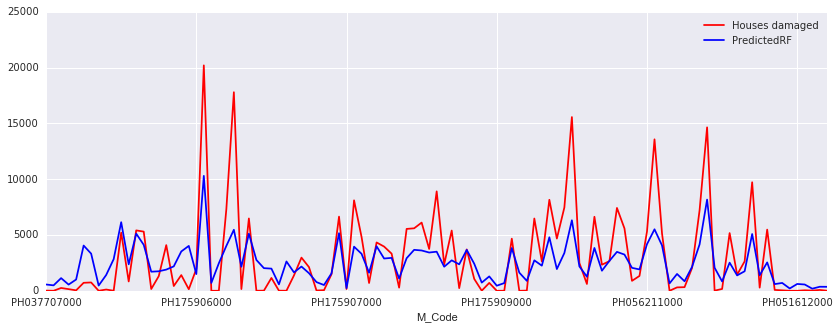

In [167]:
outcome = pd.DataFrame({'Houses damaged': y3_test, 'PredictedRF': predicted3_test})
outcome.plot(figsize=(14, 5), color=['red', 'blue', 'darkgreen'])

In [168]:
results = pd.DataFrame({'MAE': mae, 'r2': r2, 'Median Error': medians}, index=[['1st typhoon', '2 first typhoons', '3 first typhoons', '3 typhoons crossvalidation']])

In [169]:
results

,MAE,Median Error,r2
1st typhoon,1665.311011,619.755912,0.076118
2 first typhoons,1563.657772,831.995716,0.390970
3 first typhoons,1750.559184,1075.511888,0.551774
3 typhoons crossvalidation,1869.868667,1290.036768,0.198806


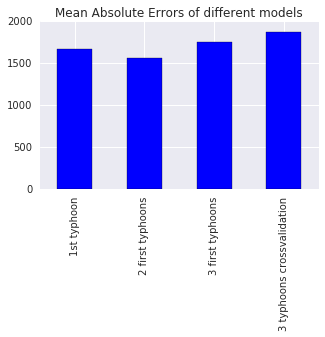

In [170]:
results.MAE.plot(kind='bar', figsize=(5, 3), title='Mean Absolute Errors of different models')

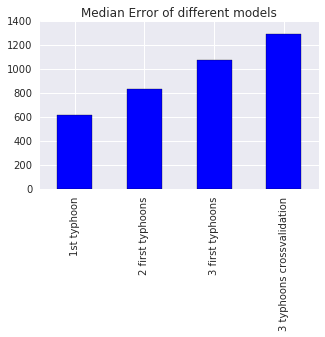

In [171]:
results['Median Error'].plot(kind='bar', figsize=(5,3), title='Median Error of different models')

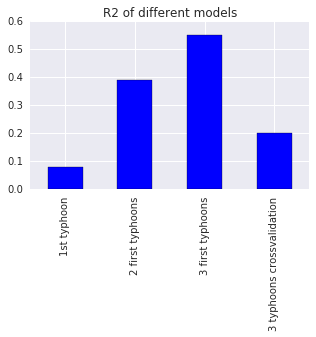

In [172]:
results.r2.plot(kind='bar', figsize=(5,3), title='R2 of different models')

<p>

## 5. Final model trained on all typhoons

In [207]:
X5_train = T[[u'Area (km2)', u'Population 2015 census',
       u'Pop. Density 2015 per km2', u'Poverty (%)', u'Rainfallme',  u'average_speed_mph', u'distance_typhoon_km', 'Poor']]

y5_train = T['Houses damaged']


print "Training shapes: ", X5_train.shape, y5_train.shape
                 


Training shapes:  (924, 8) (924,)


#### Using RandomForest as it scored better with selected best learning parameters

In [209]:
rf = RandomForestRegressor(max_features= 'log2', n_estimators= 50, min_samples_leaf= 5)

rf.fit(X5_train, y5_train )

mae_cv = []
r2_cv = []
runs = 50
for i in range(runs): 
    predicted5_train_rf = cross_validation.cross_val_predict(rf, X5_train, y5_train, cv=10)
    mae_cv.append(mean_absolute_error(y5_train, predicted5_train_rf))
    r2_cv.append(r2_score(y5_train, predicted5_train_rf))
    
print 'Cross validation MAE (average from ',runs,' runs): ', np.mean(mae_cv)
print 'Cross validation R2 (average from ',runs,' runs): ', np.mean(r2_cv)

Cross validation MAE (average from  50  runs):  1350.02980244
Cross validation R2 (average from  50  runs):  0.481417070049


## 6. Saving the model 

In [211]:
with open('Model_Hayian_Melor_Hagupit_Ramasun', 'wb') as f:
    cPickle.dump(rf, f)


[1]: http://www.rodekruis.nl